# **Question Generation** - Introduction

**Gil Levy** and **Liad Levi-Raz** (2nd notebook)

This notebook is finetuning a seq2seq model from [SimpleTransformers](https://simpletransformers.ai/), for the task of Question Generation.

The input is a dataframe with two fields **input_text** (+3 special entity markers) and **target_text**, the question to generate, which we preprocessed in the previous notebook (from the Simple Questions v2 huggingface dataset)
<br>
For example:

|input_text|	target_text|
|---|---|
|	\<se\> Comrade J \<rel\> /book/book/genre \<oe\>Autobiography	|what kind of book is comrade j |
|	\<se\> Esser \<rel\> /music/artist/genre \<oe\>Indie rock	|What kind of music does esser make?|
|	\<se\> Johnny Crawford \<rel\> /people/person/ethnicity \<oe\>European Americans	|what is johnny crawford's ethnicity|

<br>

The idea is to fine tune a pretrained [Bart based model](https://tungmphung.com/a-review-of-pre-trained-language-models-from-bert-roberta-to-electra-deberta-bigbird-and-more/#bart), which is 
"...the first bi-directional pretrained language model. It uses self-supervised learning to learn the deep meaning of words and contexts. After pretraining, the model can be adapted to different tasks as well as different datasets with minimal adjustments" ([reference](https://tungmphung.com/a-review-of-pre-trained-language-models-from-bert-roberta-to-electra-deberta-bigbird-and-more/#bart))
<br>

We tried a few seq2seq pretrained models, sich as BeRT,ROBERTA,MBART and GPT2, BART yielded the best results for our task with out dataset, achieving an average BLEU score of ~65 on a 2K test dataset for 15k training instances (and 1K validation set).
Here are some generated samples:


---
- True: 'Who is a driver for penske racing?'
- Pred: 'who is a driver for team penske'
---
- True: "whats lia orlandini's gender"
- Pred: "what is lia orlandini's gender"
---
- True: 'What is the name of a track created by jan a. p. kaczmarek'
- Pred: 'what is a song by jan a. p. kaczmarek'
---
- True: 'What type of art for is adrian kleinbergen known for'
- Pred: 'what type of art does adrian kleinbergen create'
---
- True: 'who was born in aarhus'
- Pred: 'Who was born in aarhus?'
---


<br>
Note: we also trained the same [BartForConditionalGeneration from scratch]
 (https://colab.research.google.com/drive/1BkuLm_2Rj-tak3vIP-PXYL5hmV0jQl63?usp=sharing) ( with Transformers from HuggingFace, not with Simpletransformers), and got very similiar results:
<br>

- True:What artist produced the album duane allman: an anthology, volume ii
- Pred:who is the author of duane allman: an anthology, volume ii
-------------------------------------------------------
- True:what is a township located in bollinger county?
- Pred:Name a township in bollinger county, north carolina.
-------------------------------------------------------
- True:what is the architectural style of the apsley house?
- Pred:what is the architectural style of the apsley house?
---


The preprocessing and training flow

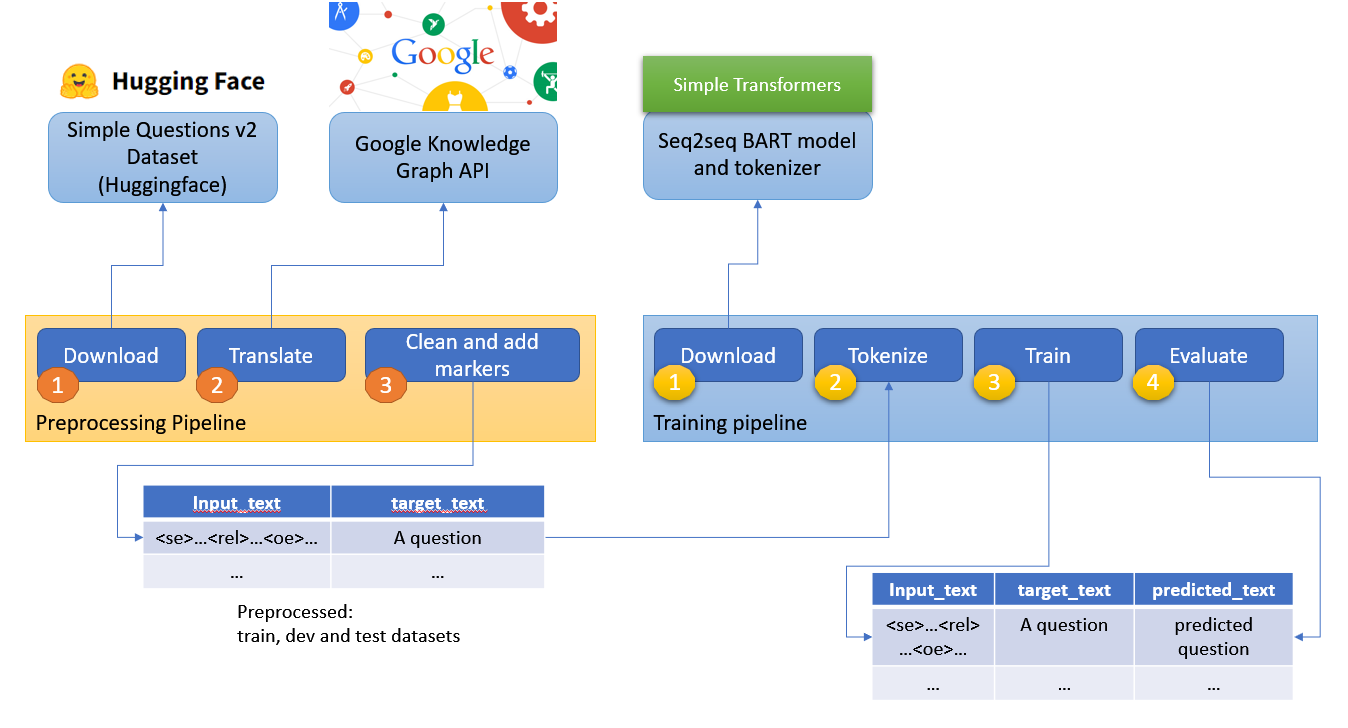

## Installing libraries


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH='/content/drive/MyDrive/2022/S2/3523_Natural_Language_Processing/notebooks/final_proj/'

SEED=42

Mounted at /content/drive


In [ ]:
#cleaning older cache
# !rm -rf cache_dir
# !rm -rf outputs/checkpoint*
# !rm -rf runs
# !rm -rf outputs/

In [ ]:
!pip install -q simpletransformers pip transformers

     |████████████████████████████████| 249 kB 8.9 MB/s 
     |████████████████████████████████| 4.4 MB 15.4 MB/s 
     |████████████████████████████████| 1.8 MB 11.2 MB/s 
     |████████████████████████████████| 6.6 MB 56.1 MB/s 
     |████████████████████████████████| 9.1 MB 49.4 MB/s 
     |████████████████████████████████| 362 kB 4.8 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 1.2 MB 59.9 MB/s 
     |████████████████████████████████| 101 kB 12.4 MB/s 
     |████████████████████████████████| 596 kB 47.3 MB/s 
     |████████████████████████████████| 181 kB 75.2 MB/s 
     |████████████████████████████████| 145 kB 70.2 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 212 kB 73.9 MB/s 
     |████████████████████████████████| 1.1 MB 56.7 MB/s 
     |████████████████████████████████| 140 kB 74.0 MB/s 
     |████████████████████████████████| 127 kB 75.8 MB/s 
     |██████████████

In [ ]:
import os
import gc
import torch
import copy
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# import sklearn
# from sklearn.metrics import confusion_matrix ,matthews_corrcoef,accuracy_score
# from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu

#NLP related
from transformers import BartTokenizer
from simpletransformers.seq2seq import Seq2SeqModel, Seq2SeqArgs

#Pytorch
import torch
import torch.nn as nn

pd.set_option("max_colwidth", 1000)
warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = 'False'

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Loading SQ2 Data

14k randonly selected training instances
+ +1k for dev
+ +2k for test

In [ ]:
!cp -rn {DRIVE_PATH}/data . 

In [ ]:
train_seq2seq_df = pd.read_csv('data/train_14k_df.csv',index_col=0)
val_seq2seq_df = pd.read_csv('data/val_14k_df.csv',index_col=0)
test_seq2seq_df = pd .read_csv('data/test_14k_df.csv',index_col=0)

In [ ]:
train_seq2seq_df.head(5)

,input_text,target_text
0,<se> Compilation album <rel> /music/album_content_type/albums <oe>iTunes Originals – New Order,what's a compilation album by new order
1,<se> Bay <rel> /geography/geographical_feature_category/features <oe>Carmarthen Bay,What's an example of a bay?
2,<se> Creeping in My Soul <rel> /music/album/genre <oe>Hard rock,what kind of music is on creeping in my soul - ep?
3,<se> 20th century <rel> /book/book_subject/works <oe>Simone de Beauvoir,what books are about the 20th century?
4,<se> San Colombano al Lambro <rel> /location/location/containedby <oe>Lombardy,Where is the location of san colombano al lambro?


In [ ]:
def reset_df(df):
  df = df.reset_index()
  df.drop(['index'],axis=1,inplace=True)
  return df
train_seq2seq_df = reset_df(train_seq2seq_df)
val_seq2seq_df = reset_df(val_seq2seq_df)
test_seq2seq_df = reset_df(test_seq2seq_df)

In [ ]:
train_seq2seq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   input_text   14000 non-null  object
 1   target_text  14000 non-null  object
dtypes: object(2)
memory usage: 218.9+ KB


In [ ]:
initial_num_records = len(train_seq2seq_df)

In [ ]:
train_seq2seq_df.shape,val_seq2seq_df.shape, test_seq2seq_df.shape

((14000, 2), (1000, 2), (2000, 2))

Extract input and output max lengths - in tokens
This is one of the model parameters which helps limit the generated text length and also shorter sequences are trained faster.

In [ ]:
# find the maximum snetence length after tokenizer
dummy_tok = BartTokenizer.from_pretrained('facebook/bart-large')
def find_max_lengths(df,percent):
  max_sent_length = 0
  max_sent_length_list = []

  max_target_length = 0
  max_target_length_list = []
  for sent in tqdm(df.iterrows()):
      input_len = len(dummy_tok(sent[1]['input_text'])['input_ids'])
      target_len = len(dummy_tok(sent[1]['target_text'])['input_ids'])
      max_sent_length_list.append(input_len)
      max_target_length_list.append(target_len)

  max_sent_length = int(np.percentile(max_sent_length_list,percent))+1
  max_target_length = int(np.percentile(max_target_length_list,percent))+1
  print('{}th percentile of input are in length:{}'.format(percent,max_sent_length))
  print('{}th percentile of target are in length:{}'.format(percent,max_target_length))
  return max_sent_length,max_target_length

a,b = find_max_lengths(train_seq2seq_df,99.5)
print ("Train Max input length after tokenization {} , max target len {}: ".format(a,b))


print (" Max input len:{}, max target len:{} after tokenization ".format(a,b))
max_len_for_seq=a # use only train with some buffer of 5
max_gen_len=b # use only train with some buffer of 5

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

0it [00:00, ?it/s]

99.5th percentile of input are in length:42
99.5th percentile of target are in length:22
Train Max input length after tokenization 42 , max target len 22: 
 Max input len:42, max target len:22 after tokenization 


In [ ]:
def clear_cache():
  gc.collect()
  torch.cuda.empty_cache()

# Basic Model - SimpleTransformers BART

In [ ]:
#hyperparams
# after very few epochs the model results are nice - but the loss continues to improve for about 6 to 10 epochs
n_epochs=15
#a small batch size for the colab GPU to work
BS=12
# a small learning rate, higher rates results were less good
LR=0.00001

#BART
MODEL_NAME="bart"
ENC_DEC_TYPE="facebook/bart-large" #=60 nice looking questions !

# Other attempts:
# MODEL_NAME="mbart" # is also quite good
# ENC_DEC_TYPE="facebook/bart-large-xsum"
# ENC_DEC_TYPE="facebook/bart-large-cnn"
# ENC_DEC_TYPE="facebook/mbart-large-50-one-to-many-mmt"=57, nice looking questions !
# ENC_DEC_TYPE="facebook/mbart-large-cc25"=52, 
# ENC_DEC_TYPE="facebook/mbart-large-50" #=56,

This is based on the example code from SimpleTransformers:
https://simpletransformers.ai/docs/seq2seq-specifics/



In [ ]:
import logging

import pandas as pd
from simpletransformers.seq2seq import (
    Seq2SeqModel,
    Seq2SeqArgs,
)

logging.basicConfig(level=logging.ERROR)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.ERROR)

model_args = Seq2SeqArgs()
model_args.num_train_epochs = n_epochs
model_args.overwrite_output_dir = True
model_args.no_save = False
model_args.evaluate_generated_text = True
model_args.evaluate_during_training = True
model_args.evaluate_during_training_verbose = True
model_args.train_batch_size=BS
model_args.learning_rate=LR
model_args.fp16=True
model_args.save_eval_checkpoints	=True #	Save a model checkpoint for every evaluation performed.
model_args.save_model_every_epoch = False #Save a model at the end of every epoch
#input
model_args.max_seq_length = max_len_for_seq
#target
model_args.max_length = max_gen_len
# model_args.min_length = 4
model_args.early_stopping = True
model_args.use_early_stopping = True
model_args.src_lang =  'en_XX'
model_args.tgt_lang =  'en_XX'

# Initialize model
model = Seq2SeqModel(
    encoder_decoder_type=MODEL_NAME, 
    encoder_decoder_name=ENC_DEC_TYPE,
    args=model_args,
    use_cuda=torch.cuda.is_available(),
)


def bleu_scr(labels, preds):
    print('5 T:',labels[:5])
    print('5 P:',preds[:5])
    bl_arr=[]
    for label, pred in zip(labels, preds): 
      bl_arr.append(sentence_bleu([pred],label))
    avg_bleu = np.mean(bl_arr)
    print('avg_bleu:{:.3f}'.format(avg_bleu))
    return avg_bleu



Downloading:   0%|          | 0.00/971M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Setting the decoder start token as the Encoder's "end of sentence" token is very important - before setting this - we got bad predictions.

In [ ]:
# for p in model.model.named_parameters():
#   if(p[1].requires_grad==True):
#     print(p[0],'\t',p[1].requires_grad)
# The decoder start token is the end sentence of the encoder !!!
model.decoder_tokenizer.decode(model.config.decoder_start_token_id)

'</s>'

In [ ]:
%%time

# Train or Inference mode
TRAINED_MODEL='bart_14k_model.zip'
!cp -nf {DRIVE_PATH}/last_model/{TRAINED_MODEL} .
INFERENCE_MODE = os.path.isfile(TRAINED_MODEL)
if(INFERENCE_MODE):
  print('Inference mode, loading best model...')
  !unzip -q -n {TRAINED_MODEL}
  model = Seq2SeqModel(
      encoder_decoder_type=MODEL_NAME, 
      encoder_decoder_name="outputs/best_model",
      args=model_args,
      use_cuda=torch.cuda.is_available(),
  )
  print('Best model loaded.')
else:
  print('Training mode')


Inference mode, loading best model...
Best model loaded.
CPU times: user 4.09 s, sys: 2.02 s, total: 6.1 s
Wall time: 1min 40s


## Train

In [ ]:
%%time

if(not INFERENCE_MODE):
  clear_cache()

  start = datetime.now()

  # Train the model
  steps,details = model.train_model(
      train_seq2seq_df, eval_data=val_seq2seq_df, bleu=bleu_scr
  )

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 18.6 µs


In [ ]:
def loss_graph(loss_train_arr , loss_dev_arr , bleu_train_arr , bleu_dev_arr , test_name = 'Dev'):
    fig, ax = plt.subplots(1, 2,figsize=(14, 5))

    ax[0].set_title('Loss vs Epoch')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    # ax[0].set_yscale('log')
    ax[0].plot(loss_train_arr,label="Train loss")
    ax[0].plot(loss_dev_arr,  label="{} loss".format(test_name))
    ax[0].legend()
        
    ax[1].set_title('bleu vs Epoch')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('bleu')
    # ax[0].set_yscale('log')
    ax[1].plot(bleu_train_arr,  label="Train bleu")
    ax[1].plot(bleu_dev_arr,  label="{} bleu".format(test_name))
    ax[1].legend()  

if(not INFERENCE_MODE):
  loss_graph(details['train_loss'],details['eval_loss'],[],details['bleu'])

## Evaluate

In [ ]:
# Evaluate the model on "train" expecting good results
results = model.eval_model(train_seq2seq_df[:1000], bleu=bleu_scr)
results

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/125 [00:00<?, ?it/s]

5 T: ["what's a compilation album by new order", "What's an example of a bay?", 'what kind of music is on creeping in my soul - ep?', 'what books are about the 20th century?', 'Where is the location of san colombano al lambro?']
5 P: ['what is a compilation album by new order', 'what is a bay in north carolina', 'what kind of music is creeping in my soul', 'what is a book written about the 20th century', 'where is san colombano al lambro located?']
avg_bleu:0.649


{'bleu': 0.6494554156346289, 'eval_loss': 0.24444290614128114}

In [ ]:
# Evaluate the model on test
results = model.eval_model(test_seq2seq_df,bleu=bleu_scr)
results

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/250 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/250 [00:00<?, ?it/s]

5 T: ['Name a notable teacher', 'where was debi gliori born', 'What type of music is watch out! classified as', "where in australia was james plimsoll's place of death?", 'what is the capital of chemnitzer land']
5 P: ['Name a teacher.', 'where was debi gliori born', 'what kind of music is watch out!', 'where did james plimsoll die', 'what is the capital of chemnitzer land']
avg_bleu:0.637


{'bleu': 0.6373718194576851, 'eval_loss': 0.30359244710206984}

In [ ]:
print('MODEL Generation CONFIG')
print('model.training=',model.model.training)
# print('decoder_start_token_id=',model.config.decoder.pad_token_id)
print('num_beams=',model.config.num_beams,)
print('max_length=',model.config.max_length,)
print('length_penalty=',model.config.length_penalty,)
print('early_stopping=',model.config.early_stopping,)
print('repetition_penalty=',model.config.repetition_penalty,)
print('do_sample=',model.config.do_sample,)
print('top_k=',model.config.top_k,)
print('top_p=',model.config.top_p,)
print('num_return_sequences=',model.config.num_return_sequences)

MODEL Generation CONFIG
model.training= False
num_beams= 4
max_length= 20
length_penalty= 1.0
early_stopping= True
repetition_penalty= 1.0
do_sample= False
top_k= 50
top_p= 1.0
num_return_sequences= 1


## Blue score  Evaluation 

In [ ]:
# The following function generates a dataframe with blue score per relation
def bleu_scr_result(df, preds):
    bl_arr = []
    rel_arr = []
    for indx , row in enumerate(df.iterrows()):
        row_data = row[1]
        label = row_data['target_text']
        pred  = preds[indx]
        bl_arr.append(sentence_bleu([pred],label))
        rel = row_data['input_text'].split('<rel>')[1].split('<oe>')[0]
        rel_arr.append(rel)
    blue_df = pd.DataFrame()
    blue_df ['relation'] = rel_arr
    blue_df ['blue socre'] = bl_arr
    return blue_df

In [ ]:
test_predict_list = model.predict(
        test_seq2seq_df['input_text'].tolist()
    )

Generating outputs:   0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
blue_score_df = bleu_scr_result(test_seq2seq_df , test_predict_list)

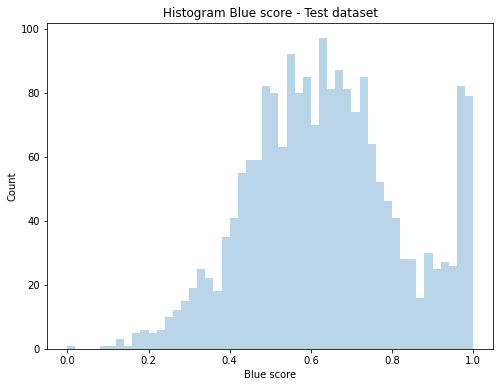

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title('Histogram Blue score - Test dataset')
ax.set_xlabel('Blue score')
ax.set_ylabel('Count')
ax.hist(blue_score_df['blue socre'],  bins = 50 , alpha=0.3)
print ("")

In [ ]:
def extract_relation(df):
    rel_arr = []
    for indx , row in enumerate(df.iterrows()):
        row_data = row[1]
        rel = row_data['input_text'].split('<rel>')[1].split('<oe>')[0]
        rel_arr.append(rel)
    return rel_arr

train_rel_list = extract_relation(train_seq2seq_df)

### Analyze how realtion frequency in the train effect the BLEU test score

In [ ]:
# Find  the most and least realtions in the train 

index_array , count_array = np.unique(train_rel_list ,return_index=True , return_counts = True)[1:3]

percentile_hi = np.percentile(count_array , 99.7)
percentile_lo = np.percentile(count_array , 85)

count_index_array_hi = count_array > percentile_hi
count_index_array_lo = count_array <  percentile_lo

count_hi = count_array[count_index_array_hi].sum()
count_lo = count_array[count_index_array_lo].sum()


unique_hi_indexes = index_array[count_index_array_hi]
unique_lo_indexes = index_array[count_index_array_lo]

print ("Train high frequent  realtion instance:")
print ("Unique instance " , unique_hi_indexes.size )
print ("Total amount of high instances " , count_hi ,"/ ", train_seq2seq_df.shape[0])

print ("\nTrain Low frequent realtion instance:")
print ("Unique instance " , unique_lo_indexes.size )
print ("Total amount of high instances " , count_lo ,"/ ", train_seq2seq_df.shape[0])


Train high frequent  realtion instance:
Unique instance  3
Total amount of high instances  1887 /  14000

Train Low frequent realtion instance:
Unique instance  636
Total amount of high instances  2212 /  14000


In [ ]:
rel_hi_arr = []
rel_lo_arr = []

for index in unique_hi_indexes:
    rel_hi_arr.append(train_rel_list[index])

print ("\n")
for index in unique_lo_indexes:
    rel_lo_arr.append(train_rel_list[index])

In [ ]:
blue_hi_freq   = []
blue_lo_freq   = []
blue_zero_freq = []


hi_freq_rel_cnt = 0
lo_freq_rel_cnt = 0
zero_freq_rel_cnt = 0

for row in blue_score_df.iterrows():
    row_data = row[1]
    rel = row_data['relation']
    if rel in rel_hi_arr:
        blue_hi_freq.append(row_data['blue socre'])
        hi_freq_rel_cnt += 1
    elif  rel in rel_lo_arr:
        blue_lo_freq.append(row_data['blue socre'])
        lo_freq_rel_cnt += 1
    else:
        blue_zero_freq.append(row_data['blue socre'])
        zero_freq_rel_cnt += 1 
        
print (" Hi freq relations instances in test " , hi_freq_rel_cnt)
print (" Lo freq relations instances in test " , lo_freq_rel_cnt)
print (" zero freq relations instances in test " , zero_freq_rel_cnt)

 Hi freq relations instances in test  262
 Lo freq relations instances in test  291
 zero freq relations instances in test  1447


Mean: 0.6737810078957711
Mean: 0.6407410878980232
Mean: 0.6301018370893942


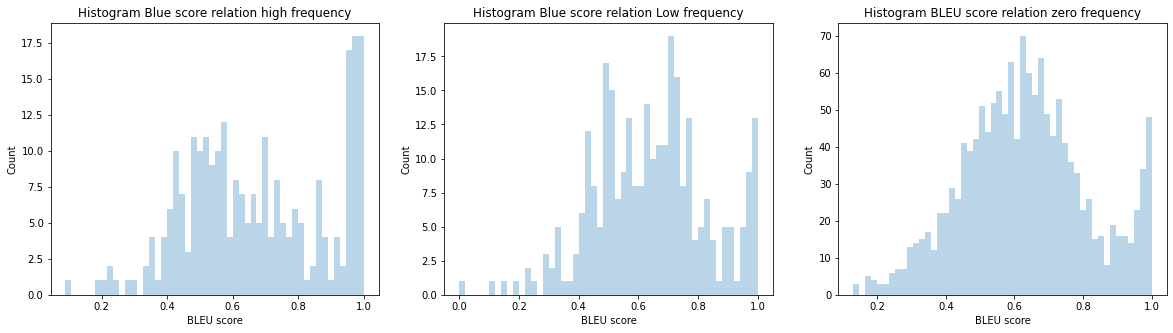

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].set_title('Histogram Blue score relation high frequency')
ax[0].set_xlabel('BLEU score')
ax[0].set_ylabel('Count')
ax[0].hist(blue_hi_freq,  bins = 50 , alpha=0.3)
print ("Mean: {}".format(np.array(blue_hi_freq).mean()))

ax[1].set_title('Histogram Blue score relation Low frequency')
ax[1].set_xlabel('BLEU score')
ax[1].set_ylabel('Count')
ax[1].hist(blue_lo_freq,  bins = 50 , alpha=0.3)
print ("Mean: {}".format(np.array(blue_lo_freq).mean()))

ax[2].set_title('Histogram BLEU score relation zero frequency')
ax[2].set_xlabel('BLEU score')
ax[2].set_ylabel('Count')
ax[2].hist(blue_zero_freq,  bins = 50 , alpha=0.3)
print ("Mean: {}".format(np.array(blue_zero_freq).mean()))


### Analyze of BLEU score distribution vs relations

In [ ]:
min_frequency_threshold1 = 10
rel_dict1  = {}
for (rel, group) in blue_score_df.groupby('relation'): 
    if group.shape[0] >= min_frequency_threshold1:
        rel_dict1[rel] = group['blue socre'].mean()

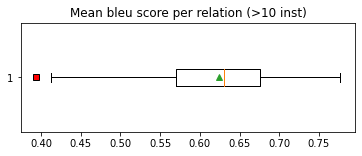

In [ ]:
red_square = dict(markerfacecolor='r', marker='s')
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.set_title('Mean bleu score per relation (>10 inst)')
ax.boxplot(rel_dict1.values() , vert = False , flierprops=red_square , showmeans = True)
print ("")

### Analyze of BLEU score distribution for speific   relations (Those that are high frequency  in Test )

In [ ]:
min_frequency_threshold2 = 50
rel_dict2  = {}
for (rel, group) in blue_score_df.groupby('relation'): 
    if group.shape[0] >= min_frequency_threshold2:
        rel_dict2[rel] = group


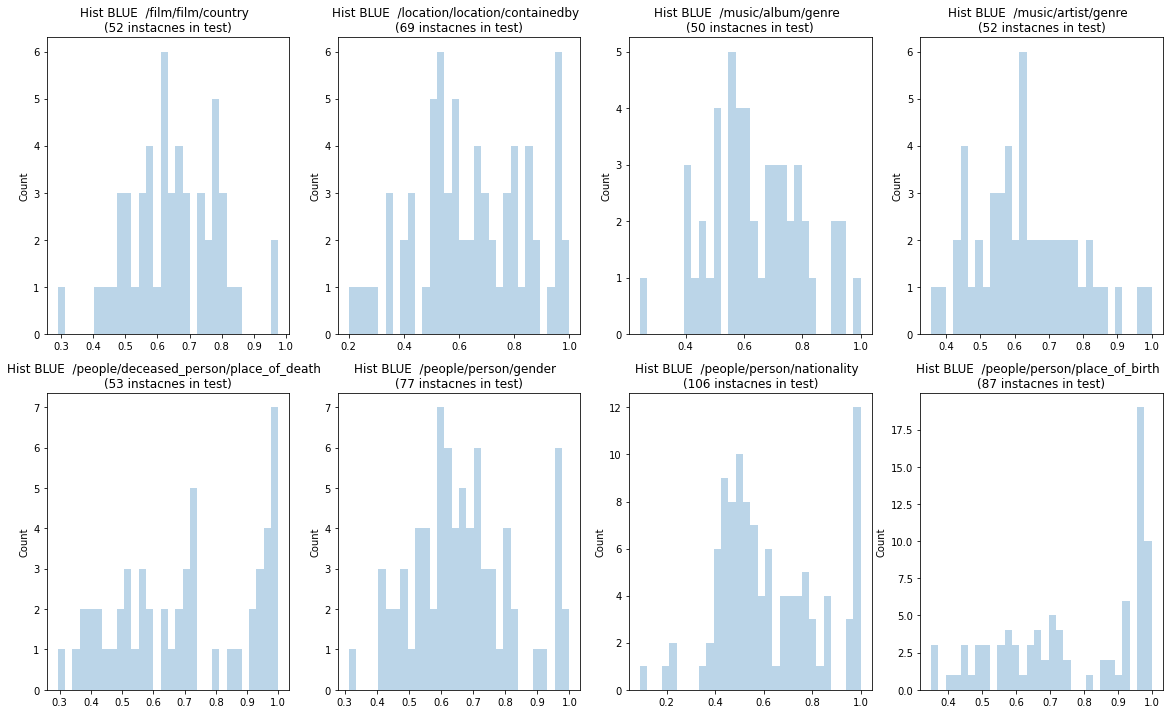

In [ ]:
num_in_col = 4

fig, axes = plt.subplots( int(len(rel_dict2)/num_in_col), num_in_col, figsize=(20, 12))  

for idx , rel  in enumerate(rel_dict2.keys()):   
    col = idx%num_in_col
    row = int(idx/num_in_col)  
    df  = rel_dict2[rel]
    axes[row,col].set_title('Hist BLUE {} \n({} instacnes in test)'.format(rel , df.shape[0]))
    axes[row,col].hist(df['blue socre'],  bins = 30 , alpha=0.3)
   # axes[row,col].set_xlabel("BLEU score")
    axes[row,col].set_ylabel("Count")


In [ ]:
rel_examine = ' /people/person/nationality '

## Add the pairs bleu score column


In [ ]:
test_pred_df = test_seq2seq_df.copy()
test_pred_df['pred'] = test_predict_list

pd.set_option('display.precision',4)

In [ ]:
bl_sc = []
for t,p in tqdm(zip(list(test_pred_df['target_text'].values),list(test_pred_df['pred'].values))):
  bl_sc.append(max(1e-04,sentence_bleu([t],p)))

test_pred_df['bleu'] = bl_sc
test_pred_df['bleu'].mean()

test_rel_list = extract_relation(test_seq2seq_df)
test_pred_df['realtion'] = test_rel_list

0it [00:00, ?it/s]

In [ ]:
df_examine = test_pred_df[test_pred_df['realtion'] == rel_examine]

In [ ]:
df_examine_hi = df_examine.sort_values(by='bleu',ascending=False)
df_examine_hi[0:5].drop('realtion' , axis = 1)

,input_text,target_text,pred,bleu
975,<se> Hwang Byung-ju <rel> /people/person/nationality <oe>South Korea,what is hwang byung-ju's nationality?,what is hwang byung-ju's nationality?,1.0
500,<se> Alan Goodall <rel> /people/person/nationality <oe>England,what is alan goodall's nationality?,what is alan goodall's nationality?,1.0
1787,<se> Tim Yeo <rel> /people/person/nationality <oe>United Kingdom,what is tim yeo's nationality?,what is tim yeo's nationality?,1.0
454,<se> Frances Weintraub Lax <rel> /people/person/nationality <oe>United States,what is frances weintraub lax's nationality?,what is frances weintraub lax's nationality?,1.0
169,<se> Mastur <rel> /people/person/nationality <oe>Indonesia,what is the nationality of mastur,what is the nationality of mastur,1.0


In [ ]:
df_examine_lo = df_examine.sort_values(by='bleu',ascending=True)
df_examine_lo[0:5].drop('realtion' , axis = 1)

,input_text,target_text,pred,bleu
1914,<se> Emperor Magus Caligula <rel> /people/person/nationality <oe>Sweden,Where is masse broberg from,what is emperor magus caligula's nationality?,0.1028
1700,<se> Roy Worters <rel> /people/person/nationality <oe>Canada,Where was Roy Worters born?,what is the nationality of roy worters,0.2077
650,<se> Adalita <rel> /people/person/nationality <oe>Australia,which country does adalita srsen represent,what is adalita's nationality?,0.2222
1609,<se> Volkmar Leif Gilbert <rel> /people/person/nationality <oe>Germany,Which country was volkmar welzel from,what is the nationality of volkmar leif gilbert,0.2310
474,<se> Samuel Roy McKelvie <rel> /people/person/nationality <oe>United States,is samuel roy mckelvie a citizen of the united states or australia,what is samuel roy mckelvie's nationality?,0.3528


**Analyze a relation that has low quality question also by eye**

In [ ]:
rel_examine = ' /people/ethnicity/people '
df_examine = test_pred_df[test_pred_df['realtion'] == rel_examine]


In [ ]:
df_examine_hi = df_examine.sort_values(by='bleu',ascending=False)
df_examine_hi[0:5].drop('realtion' , axis = 1)

,input_text,target_text,pred,bleu
1993,<se> Jewish people <rel> /people/ethnicity/people <oe>Lionel Stander,who is a jewish person?,who is a jewish person,0.9556
51,<se> English people <rel> /people/ethnicity/people <oe>Anthea Turner,who is an english tv personal,who is an english person,0.7508
1557,<se> Filipino Americans <rel> /people/ethnicity/people <oe>Jessica Bangkok,who is a filipino american,who is a Filipino American actress,0.6357
1994,<se> African Americans <rel> /people/ethnicity/people <oe>Pete Mickeal,What is the name of someone who is african american,who is african american american?,0.4368
1331,<se> African Americans <rel> /people/ethnicity/people <oe>Elston Turner,Who is a retired african american basketball payer?,who is african american american,0.4123


In [ ]:
df_examine_lo = df_examine.sort_values(by='bleu',ascending=True)
df_examine_lo[0:5].drop('realtion' , axis = 1)

,input_text,target_text,pred,bleu
1252,<se> Castilians <rel> /people/ethnicity/people <oe>Fernando Torres,Who's somebody that identifies with the castilian people,who is a castilians,0.0868
1293,<se> Jewish people <rel> /people/ethnicity/people <oe>Moshe Leib Lilienblum,What is the name of a person of the jewish people ethnicity?,who is a jewish person,0.1403
892,<se> Indian people <rel> /people/ethnicity/people <oe>Vinod Khanna,who's a film actor who is also of the indian people,who is an Indian person,0.1899
1290,<se> Jewish people <rel> /people/ethnicity/people <oe>Salman Schocken,who businessman part of the jewish people,who is a jewish person,0.2483
629,<se> White people <rel> /people/ethnicity/people <oe>Valerie Bertinelli,Who is a person of the caucasian race,who is a white person,0.3054


## Predict

Predicting on some of the test samples:

In [ ]:
inp_samples = [str(inp) for inp in test_seq2seq_df['input_text'][1:5].values]
tgt_samples = [str(tgt) for tgt in test_seq2seq_df['target_text'][1:5].values]

prds = model.predict(inp_samples)
bleus = []
for p,t in zip(prds,tgt_samples):
  print('True: ',t.strip().capitalize())
  print('Pred: ',p.strip().capitalize())
  b = sentence_bleu([p],t)
  print('BLEU:{:.2f}'.format(b))
  print('---------------------------')


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True:  Where was debi gliori born
Pred:  Where was debi gliori born
BLEU:1.00
---------------------------
True:  What type of music is watch out! classified as
Pred:  What kind of music is watch out!
BLEU:0.55
---------------------------
True:  Where in australia was james plimsoll's place of death?
Pred:  Where did james plimsoll die
BLEU:0.36
---------------------------
True:  What is the capital of chemnitzer land
Pred:  What is the capital of chemnitzer land
BLEU:1.00
---------------------------


### Predicting on totally new texts

In [ ]:
# model.config.num_return_sequences =40
# Use the model for prediction of some unseen facts
texts = [
              "<se> Tel Aviv <rel> /location/location/contains <oe>Yarkon Stream", #different names of entities but known relation
              "<se> Amir <rel> lecturer <oe> Natural Language Processing course in Reichman university",  #new relations
              "The lecturer of the natural language course in Reichman university is Amir" #totally unstructured new "fact"
        ]
pprint(
    model.predict(texts)
)
# results

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['what is a stream in tel aviv',
 "what is the name of amir's academic subject",
 'who is the lecturer of the natural language course in reichman university']


## For Enhanced Model - Generate a few questions

In [ ]:
def generate_few_questions(model1,input,k=0.,p=1.,n_beams=3,method='beam',num_return_sequences=15):
  '''generate k questions from given text'''
  # model1.eval()
  dev_input = model1.encoder_tokenizer.encode_plus(input,padding='max_length',
                                max_length = max_len_for_seq,
                                truncation=True,
                                return_tensors="pt")
  input_ids = dev_input['input_ids'].to(device)
  att_masks = dev_input['attention_mask'].to(device)
  if(method=='beam'):
    outputs = model1.model.generate(
      input_ids=input_ids,
      attention_mask=att_masks,
      max_length=max_gen_len+20,
      num_beams=n_beams+10,
      num_return_sequences=num_return_sequences*2,
      no_repeat_ngram_size=2,
      early_stopping=True
      )
  elif(method=='sample'):
    outputs = model1.model.generate(
      input_ids, 
      do_sample=True, 
      max_length=max_gen_len+20, 
      top_k=k,  #top_k=0 deactivate top_k sampling
      temperature=1., #low TEMP turns to Greedy
      top_p=p, #top_p=0 deactivate top_p sampling
      num_return_sequences=num_return_sequences
    )
  else:
    print('method not supported')
    return
  Questions = [model1.decoder_tokenizer.decode(out, skip_special_tokens=True) for out in outputs]
  return set([Question.capitalize() for Question in Questions])


### Top p sampling generation

In [ ]:
for text in texts[:2]:
  print('------------------------\n'+text)
  generated = generate_few_questions(model,text,p=0.95,method='sample')
  # pprint([g for g in generated if not g.endswith('?')])
  pprint(generated)

------------------------
<se> Tel Aviv <rel> /location/location/contains <oe>Yarkon Stream
{'What is a stream in tel aviv',
 'What is a stream located in tel aviv',
 'What is the name of a stream in tel aviv',
 'What stream is located in tel aviv?'}
------------------------
<se> Amir <rel> lecturer <oe> Natural Language Processing course in Reichman university
{"What is amir's job?",
 "What is the name of amir's academic subject",
 "What is the name of amir's academic subject?",
 "What is the name of amir's course in reichman university",
 "What is the name of amir's university",
 "What is the name of amir's university?"}


### Top k sampling generation

In [ ]:
for text in texts[:2]:
  print('------------------------\n'+text)
  generated = generate_few_questions(model,text,k=40,method='sample')
  pprint(generated)

------------------------
<se> Tel Aviv <rel> /location/location/contains <oe>Yarkon Stream
{'What is a stream in tel aviv',
 'What is a stream in tel aviv?',
 'What is a stream located in tel aviv',
 'What is located in tel aviv?',
 'What is the name of a stream in tel aviv?',
 'What stream is located in tel aviv?'}
------------------------
<se> Amir <rel> lecturer <oe> Natural Language Processing course in Reichman university
{"What is amir's academic subject?",
 "What is the name of amir germany's lecturer?",
 "What is the name of amir's academic subject",
 "What is the name of amir's academic subject?",
 "What is the name of amir's university?",
 'What is the name of the lecturer amir '}


### Beam search generation

> Most diverse rephrased questions were generated by the Beam search - which is known to work well in cases where the generated text size is more or less known (like in translation)



In [ ]:
for text in texts[:2]:
  print('------------------------\n'+text)
  generated = generate_few_questions(model,text,n_beams=65,method='beam')
  #some filtering as we get the same question twice - once with a '?'
  pprint([g for g in generated if not g.endswith('?')])


------------------------
<se> Tel Aviv <rel> /location/location/contains <oe>Yarkon Stream
["What's a stream in tel aviv",
 'What is a stream found in tel aviv',
 'What is located in tel aviv',
 'What is a stream in tel aviv',
 'What stream is located in tel aviv',
 'Name a stream in tel aviv.',
 'Which stream is located in tel aviv',
 'What is a stream located in tel aviv',
 "What's a stream located in tel aviv"]
------------------------
<se> Amir <rel> lecturer <oe> Natural Language Processing course in Reichman university
['What is a subject taught by amir',
 'Amir is a lecturer in reichman university',
 'Amir is a lecturer at reichman university',
 'What is an academic subject taught by amir',
 "What is the name of amir's university",
 "What is the name of amir's academic subject",
 'What is the name of a lecturer named amir']


### Analyze the relation between the rank of a generated question and its bleu score

Basically we expected to see that the lower ranks (1,2,...) have a higher BLEU score (closer to 1), but in many cases the BLEU score "lies", where the rank is actually indicating a good question (meaning the better ranks have also a lower BLEU scores than the following ranks)

In [ ]:
def run_analyze(model,df,p=1.,k=0.,method='beam',n_ret_seq=15,n_beams=45,from_i = 1,to_i= 5):
  inp_samples = [str(inp) for inp in df['input_text'][from_i:to_i].values]
  tgt_samples = [str(tgt) for tgt in df['target_text'][from_i:to_i].values]
  prds2 = []
  for text in inp_samples:
    gend = generate_few_questions(model,text,n_beams=n_beams,method=method,k=k,p=p,num_return_sequences=n_ret_seq)
    if(method=='beam'):
      prds2.append([g for g in gend if not g.endswith('?')])
    else:
      prds2.append([g for g in gend])

  f,axs = plt.subplots(1,len(inp_samples),figsize=(16,6),sharey=True)
  j=0
  for p,t in zip(prds2,tgt_samples):
    print('True: ',t)
    ks,bleus = [],[]
    for k,gp in enumerate(p):
      b = sentence_bleu([gp],t)
      print('{:2d}. BLEU:{:.2f}\tPred: {}'.format(k,b,gp))
      ks.append(k)
      bleus.append(b)
      axs[j].bar(ks,bleus)
      axs[j].set_xticks(range(len(ks)))
      axs[j].set_xlabel('generated rank')
      axs[j].set_ylabel('BLEU')
    j+=1
    print(70*'-')
  plt.tight_layout()

True:  Name a star in the constellation of carina
 0. BLEU:0.23	Pred: Name a star
 1. BLEU:0.26	Pred: What is an example of a star
 2. BLEU:0.25	Pred: What's an example of a star
 3. BLEU:0.36	Pred: What is the name of a star
----------------------------------------------------------------------
True:  What would be a mtv show
 0. BLEU:0.29	Pred: What's an example of a mtv film
 1. BLEU:0.34	Pred: What is the name of a mtv film
 2. BLEU:0.30	Pred: Name a mtv film.
 3. BLEU:0.23	Pred: What films have been produced by mtv
 4. BLEU:0.40	Pred: What is a mtv film
 5. BLEU:0.33	Pred: What is the name of a mtv movie
 6. BLEU:0.31	Pred: What is an example of a mtv film
 7. BLEU:0.29	Pred: What is a film produced by mtv
----------------------------------------------------------------------
True:  what area was affected by the may 18–21, 2013 tornado outbreak
 0. BLEU:0.91	Pred: What area was affected by the may 18 - 21, 2013 tornado outbreak
 1. BLEU:0.81	Pred: Which country was affected by the

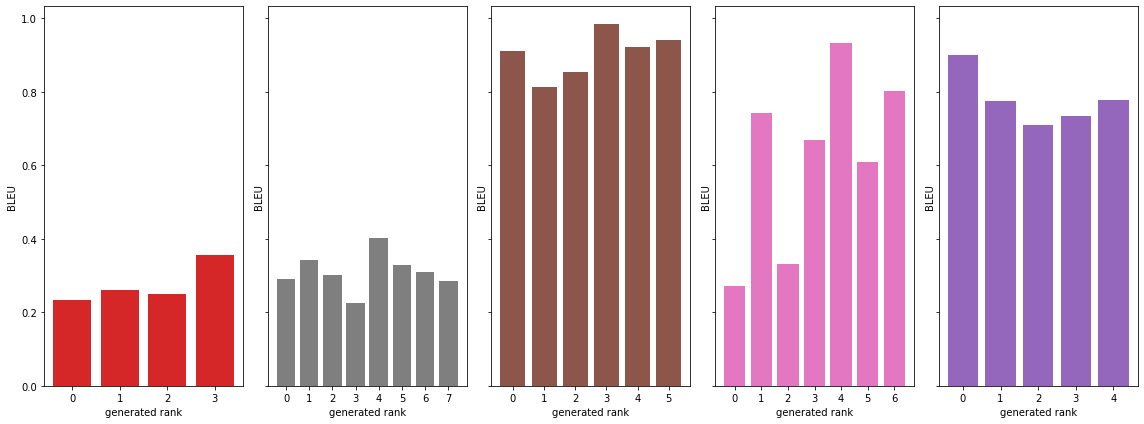

In [ ]:
#Beam
run_analyze(model,test_seq2seq_df,method='beam',n_ret_seq=8,from_i=350,to_i=355)


True:  Name a star in the constellation of carina
 0. BLEU:0.23	Pred: Name a star
 1. BLEU:0.17	Pred: What is a star?
 2. BLEU:0.26	Pred: What is an example of a star
 3. BLEU:0.17	Pred: What is a star
----------------------------------------------------------------------
True:  What would be a mtv show
 0. BLEU:0.40	Pred: What is a mtv film?
 1. BLEU:0.29	Pred: What is a film produced by mtv
 2. BLEU:0.34	Pred: What is the name of a mtv film
----------------------------------------------------------------------
True:  what area was affected by the may 18–21, 2013 tornado outbreak
 0. BLEU:0.98	Pred: What area was affected by the may 18–21, 2013 tornado outbreak
 1. BLEU:0.91	Pred: What area was affected by the may 18, 2013 tornado outbreak
----------------------------------------------------------------------
True:  what kind of music is on glory?
 0. BLEU:0.80	Pred: What kind of music is glory
 1. BLEU:0.68	Pred: What kind of music is on the album glory
------------------------------

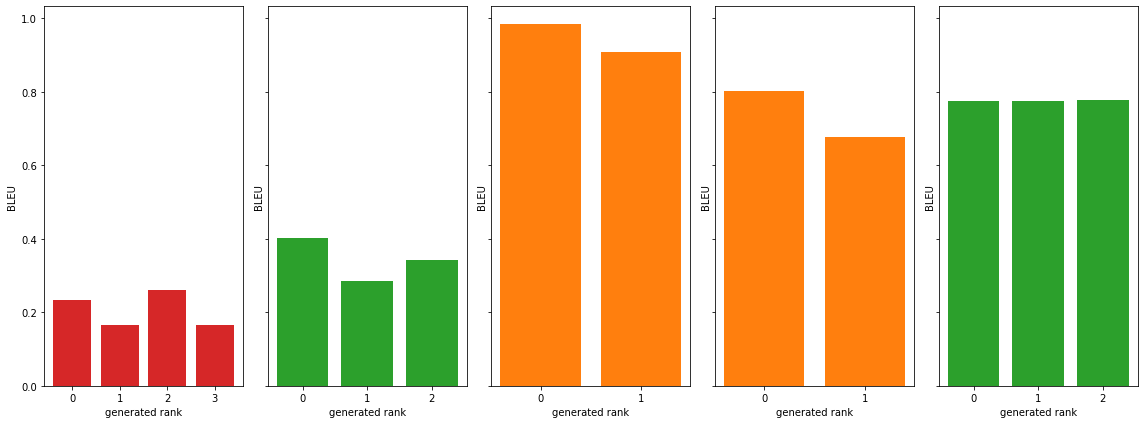

In [ ]:
#Top K Sampling
run_analyze(model,test_seq2seq_df,k=40,method='sample',from_i=350,to_i=355)

## Save results


In [ ]:
cols=['model','encoder_decoder_type','sample_size',
                                   'batch_size','lr','n_epochs','bleu_val',
                                   'bleu_tst','runtime']

In [ ]:
if(not INFERENCE_MODE):
  results_df = pd.DataFrame(columns=cols)

  results_df.loc[len(results_df)] = [MODEL_NAME,ENC_DEC_TYPE,14000,
                                   BS,LR,n_epochs,np.mean(details['bleu']),
                                   np.mean(results['bleu']),datetime.now()-start]

In [ ]:
if(not INFERENCE_MODE):
  results_df.to_csv(DRIVE_PATH + '/simple_exp.csv', mode='a', index=False,header=False)

### Experiments history

In [ ]:
df=pd.read_csv(DRIVE_PATH + '/simple_exp.csv',header=None)
df.columns=cols
df.sort_values(by='bleu_tst',ascending=False)

,model,encoder_decoder_type,sample_size,batch_size,lr,n_epochs,bleu_val,bleu_tst,runtime
6,bart,facebook/bart-large,9000,4,1.0000e-05,15,0.6363,0.6514,0 days 01:15:33.320998
9,bart,facebook/bart-large,15000,4,1.0000e-05,15,0.6323,0.6429,0 days 02:12:27.516682
8,bart,facebook/bart-large,15000,4,1.0000e-05,15,0.6323,0.6429,0 days 01:53:36.598383
10,bart,facebook/bart-large,7500,4,1.0000e-05,15,0.6361,0.6393,0 days 01:01:51.022020
14,bart,facebook/bart-large,14000,12,1.0000e-05,15,0.6361,0.6388,0 days 01:38:32.535687
11,bart,facebook/bart-large,14000,8,1.0000e-05,15,0.6366,0.6388,0 days 01:46:19.073286
13,bart,facebook/bart-large,14000,12,1.0000e-05,15,0.6357,0.6374,0 days 01:38:17.527525
12,bart,facebook/bart-large,14000,12,1.0000e-05,15,0.6357,0.6360,0 days 01:21:33.709988
7,bart,facebook/bart-large,15000,4,1.0000e-05,15,0.6324,0.6334,0 days 01:39:20.359897
4,bart,facebook/bart-large,3000,4,1.0000e-05,15,0.6305,0.6299,0 days 00:41:38.364406


In [ ]:
BACKUP=False
if(BACKUP):
  !zip {TRAINED_MODEL} outputs/best_model/*.*
  !cp -nf {TRAINED_MODEL} {DRIVE_PATH}/last_model/

## Generate and save all test results

In [ ]:
test_pred_df = test_seq2seq_df.copy()
test_pred_df['pred'] = model.predict(list(test_pred_df['input_text'].values))
pd.set_option('display.precision',4)

Generating outputs:   0%|          | 0/250 [00:00<?, ?it/s]

## add the pairs bleu score column

In [ ]:
bl_sc = []
for t,p in tqdm(zip(list(test_pred_df['target_text'].values),list(test_pred_df['pred'].values))):
  bl_sc.append(max(1e-04,sentence_bleu([t],p)))

test_pred_df['bleu'] = bl_sc
test_pred_df['bleu'].mean()

0it [00:00, ?it/s]

0.6290321789819879

In [ ]:
test_pred_df.head(3)

,input_text,target_text,pred,bleu
0,<se> Teacher <rel> /people/profession/people_with_this_profession <oe>James Sorel-Cameron,Name a notable teacher,Name a teacher.,0.5400
1,<se> Debi Gliori <rel> /people/person/place_of_birth <oe>Glasgow,where was debi gliori born,where was debi gliori born,1.0000
2,<se> Watch Out! <rel> /music/album/genre <oe>Melodic hardcore,What type of music is watch out! classified as,what kind of music is watch out!,0.5204


In [ ]:
test_pred_df.to_csv(DRIVE_PATH + '/st_bart_preds.csv', index=False)

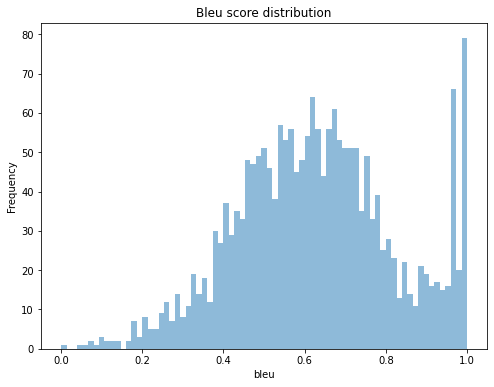

In [ ]:
f,x = plt.subplots(figsize=(8,6))
test_pred_df['bleu'].plot.hist(bins=75,alpha=0.5)
x.set_xlabel('bleu')
x.set_title('Bleu score distribution')
# x.set_title
plt.show()

## Show best results

TODO show relation vs bleu - how rare relations are scored...

Some are prefectly predicted with BLEU = 1

In [ ]:
test_pred_df.sort_values(by='bleu',ascending=False)[:5]

,input_text,target_text,pred,bleu
1452,<se> The Spanish Gypsy <rel> /film/film/directed_by <oe>D. W. Griffith,who directed the spanish gypsy,who directed the spanish gypsy,1.0
1761,<se> Catania <rel> /location/location/people_born_here <oe>Francesco Giuffrida,who was born in catania,who was born in catania,1.0
1545,<se> Cheboygan <rel> /location/location/people_born_here <oe>Scott Sigler,who was born in cheboygan,who was born in cheboygan,1.0
169,<se> Mastur <rel> /people/person/nationality <oe>Indonesia,what is the nationality of mastur,what is the nationality of mastur,1.0
1233,<se> Peter Breiner <rel> /music/artist/track <oe>Eritrea,what is a track by peter breiner,what is a track by peter breiner,1.0


## Show "worst" bleu results

Some totally rephrased questions are actually quite good 'by eye', but got a low bleu score as they don't similiar to the reference translation

In [ ]:
test_pred_df.sort_values(by='bleu',ascending=True)[:10]

,input_text,target_text,pred,bleu,relation
1593,<se> Eswatini <rel> /location/location/partially_contains <oe>Emlembe,which places partially contains swaziland?,what is a town in eswatini,0.0001,/location/location/partially_contains
1998,<se> Goalkeeper <rel> /soccer/football_position/players <oe>Carlos Gomes,who was considered to be the greatest portuguese goalkeeper in football?,who is a goalkeeper,0.0456,/soccer/football_position/players
398,<se> Boxing <rel> /martial_arts/martial_art/well_known_practitioner <oe>Philip Holiday,who is a professional boxing representative in the junior middleweight division,who is a well known boxer,0.0586,/martial_arts/martial_art/well_known_practitioner
350,<se> Star <rel> /astronomy/celestial_object_category/objects <oe>Iota Carinae,Name a star in the constellation of carina,what is a star,0.0734,/astronomy/celestial_object_category/objects
165,<se> Actor <rel> /people/profession/people_with_this_profession <oe>Kyllikki Väre,What is the name of a Finnish actress?,Name an actor.,0.0737,/people/profession/people_with_this_profession
1252,<se> Castilians <rel> /people/ethnicity/people <oe>Fernando Torres,Who's somebody that identifies with the castilian people,who is a castilians,0.0868,/people/ethnicity/people
1254,<se> Lucius Annaeus Seneca <rel> /influence/influence_node/influenced <oe>Boethius,what philosopher of the early 6th century impacted the work of seneca the younger,who was influenced by lucius annus seneca,0.0987,/influence/influence_node/influenced
504,<se> Defender <rel> /soccer/football_position/players <oe>Matt Chulis,Who is a man who plays the position defender in soccer?,who is a defender,0.1012,/soccer/football_position/players
1914,<se> Emperor Magus Caligula <rel> /people/person/nationality <oe>Sweden,Where is masse broberg from,what is emperor magus caligula's nationality?,0.1028,/people/person/nationality
640,<se> Punjab <rel> /location/location/contains <oe>Dwarka Institute of Management &amp; Technology,"Which is an educational institution for management located in punjab, india?",what is a university in punjab,0.1090,/location/location/contains


## Analyze worse BLEU results

Comparing bad generated questions with others of the same relation



In [ ]:
def get_rel(txt):
  return txt.split('<rel>')[1].split('<oe')[0].strip()

In [ ]:
def add_relation_col(df):
  all_rels = [get_rel(inpt) for inpt in list(df['input_text'].values)]
  df['relation'] = all_rels
  return df

test_pred_df = add_relation_col(test_pred_df)

test_pred_df.head()

,input_text,target_text,pred,bleu,relation
0,<se> Teacher <rel> /people/profession/people_with_this_profession <oe>James Sorel-Cameron,Name a notable teacher,Name a teacher.,0.5400,/people/profession/people_with_this_profession
1,<se> Debi Gliori <rel> /people/person/place_of_birth <oe>Glasgow,where was debi gliori born,where was debi gliori born,1.0000,/people/person/place_of_birth
2,<se> Watch Out! <rel> /music/album/genre <oe>Melodic hardcore,What type of music is watch out! classified as,what kind of music is watch out!,0.5204,/music/album/genre
3,<se> James Plimsoll <rel> /people/deceased_person/place_of_death <oe>Hobart,where in australia was james plimsoll's place of death?,where did james plimsoll die,0.2748,/people/deceased_person/place_of_death
4,<se> Chemnitzer Land <rel> /base/aareas/schema/administrative_area/capital <oe>Glauchau,what is the capital of chemnitzer land,what is the capital of chemnitzer land,1.0000,/base/aareas/schema/administrative_area/capital


In [ ]:
worst_bleu_df = test_pred_df.sort_values(by='bleu',ascending=True)[:15]
worst_bleu_df.head(5)

,input_text,target_text,pred,bleu,relation
1593,<se> Eswatini <rel> /location/location/partially_contains <oe>Emlembe,which places partially contains swaziland?,what is a town in eswatini,0.0001,/location/location/partially_contains
1998,<se> Goalkeeper <rel> /soccer/football_position/players <oe>Carlos Gomes,who was considered to be the greatest portuguese goalkeeper in football?,who is a goalkeeper,0.0456,/soccer/football_position/players
398,<se> Boxing <rel> /martial_arts/martial_art/well_known_practitioner <oe>Philip Holiday,who is a professional boxing representative in the junior middleweight division,who is a well known boxer,0.0586,/martial_arts/martial_art/well_known_practitioner
350,<se> Star <rel> /astronomy/celestial_object_category/objects <oe>Iota Carinae,Name a star in the constellation of carina,what is a star,0.0734,/astronomy/celestial_object_category/objects
165,<se> Actor <rel> /people/profession/people_with_this_profession <oe>Kyllikki Väre,What is the name of a Finnish actress?,Name an actor.,0.0737,/people/profession/people_with_this_profession


### Showing for every relation of the "worst BLEU", the 5 other instances, with the **same relation**, with the **lowest** BLEU scores

- It seems like in most of examples the other 5 predictions also got lower scores for these relations (except for the first row - the "worse" instance itself)
- Again in most cases the BLEU score does not reflect the quality of the question, the questions are mostly good ones.
- Examples 0 an 2 have very few instances.

In [ ]:
for i,r in enumerate(worst_bleu_df['relation']):
  print('***********START({})***********'.format(i))
  txt_5_lines = test_pred_df[test_pred_df['relation']==r].sort_values(by='bleu',ascending=True)[:5]
  pprint(txt_5_lines.iloc[0])
  display(txt_5_lines)
  print('***********END ({})***********\n\n'.format(i))


***********START(0)***********
input_text     <se> Eswatini <rel> /location/location/partially_contains <oe>Emlembe
target_text                               which places partially contains swaziland?
pred                                                      what is a town in eswatini
bleu                                                                          0.0001
relation                                       /location/location/partially_contains
Name: 1593, dtype: object


,input_text,target_text,pred,bleu,relation
1593,<se> Eswatini <rel> /location/location/partially_contains <oe>Emlembe,which places partially contains swaziland?,what is a town in eswatini,0.0001,/location/location/partially_contains


***********END (0)***********


***********START(1)***********
input_text     <se> Goalkeeper <rel> /soccer/football_position/players <oe>Carlos Gomes
target_text    who was considered to be the greatest portuguese goalkeeper in football?
pred                                                                who is a goalkeeper
bleu                                                                             0.0456
relation                                              /soccer/football_position/players
Name: 1998, dtype: object


,input_text,target_text,pred,bleu,relation
1998,<se> Goalkeeper <rel> /soccer/football_position/players <oe>Carlos Gomes,who was considered to be the greatest portuguese goalkeeper in football?,who is a goalkeeper,0.0456,/soccer/football_position/players
504,<se> Defender <rel> /soccer/football_position/players <oe>Matt Chulis,Who is a man who plays the position defender in soccer?,who is a defender,0.1012,/soccer/football_position/players
1304,<se> Defender <rel> /soccer/football_position/players <oe>Tony Donatelli,what is the name of a football defender,who is a defender,0.2015,/soccer/football_position/players
1858,<se> Forward <rel> /soccer/football_position/players <oe>Manuel Fischer,what is the name of a forward player,who plays forward in football,0.3724,/soccer/football_position/players
381,<se> Goalkeeper <rel> /soccer/football_position/players <oe>Mehdi Rahmati,what is the name of a goalkeeper in soccer,who is a goalkeeper in football,0.4583,/soccer/football_position/players


***********END (1)***********


***********START(2)***********
input_text     <se> Boxing <rel> /martial_arts/martial_art/well_known_practitioner <oe>Philip Holiday
target_text           who is a professional boxing representative in the junior middleweight division
pred                                                                        who is a well known boxer
bleu                                                                                           0.0586
relation                                            /martial_arts/martial_art/well_known_practitioner
Name: 398, dtype: object


,input_text,target_text,pred,bleu,relation
398,<se> Boxing <rel> /martial_arts/martial_art/well_known_practitioner <oe>Philip Holiday,who is a professional boxing representative in the junior middleweight division,who is a well known boxer,0.0586,/martial_arts/martial_art/well_known_practitioner
1283,<se> Boxing <rel> /martial_arts/martial_art/well_known_practitioner <oe>David Rodriguez,who is well known for boxing,who is a well known boxer,0.6873,/martial_arts/martial_art/well_known_practitioner


***********END (2)***********


***********START(3)***********
input_text     <se> Star <rel> /astronomy/celestial_object_category/objects <oe>Iota Carinae
target_text                                       Name a star in the constellation of carina
pred                                                                          what is a star
bleu                                                                                  0.0734
relation                                        /astronomy/celestial_object_category/objects
Name: 350, dtype: object


,input_text,target_text,pred,bleu,relation
350,<se> Star <rel> /astronomy/celestial_object_category/objects <oe>Iota Carinae,Name a star in the constellation of carina,what is a star,0.0734,/astronomy/celestial_object_category/objects
455,<se> Asteroid <rel> /astronomy/celestial_object_category/objects <oe>14327 Lemke,which asteroid was discovered in 1980?,what is an example of an asteroid,0.2858,/astronomy/celestial_object_category/objects
1271,<se> Asteroid <rel> /astronomy/celestial_object_category/objects <oe>7215 Gerhard,"what asteroid was discovered on march 16, 1977",what is an example of an asteroid,0.2921,/astronomy/celestial_object_category/objects
1043,<se> Asteroid <rel> /astronomy/celestial_object_category/objects <oe>(12662) 1978 CK,what is an asteroid discovered in 1978,what is an asteroid,0.3679,/astronomy/celestial_object_category/objects
1567,<se> Asteroid <rel> /astronomy/celestial_object_category/objects <oe>42531 McKenna,What is the name of an object of an asteroid?,what is an example of an asteroid,0.5052,/astronomy/celestial_object_category/objects


***********END (3)***********


***********START(4)***********
input_text     <se> Actor <rel> /people/profession/people_with_this_profession <oe>Kyllikki Väre
target_text                                               What is the name of a Finnish actress?
pred                                                                              Name an actor.
bleu                                                                                      0.0737
relation                                          /people/profession/people_with_this_profession
Name: 165, dtype: object


,input_text,target_text,pred,bleu,relation
165,<se> Actor <rel> /people/profession/people_with_this_profession <oe>Kyllikki Väre,What is the name of a Finnish actress?,Name an actor.,0.0737,/people/profession/people_with_this_profession
671,<se> Actor <rel> /people/profession/people_with_this_profession <oe>Jelani Asar Snipes,Who is your favorite actor?,Name an actor.,0.1693,/people/profession/people_with_this_profession
453,<se> Politician <rel> /people/profession/people_with_this_profession <oe>Didier Ratsiraka,Who was a politician in Madagascar?,Name a politician.,0.2606,/people/profession/people_with_this_profession
1999,<se> Businessperson <rel> /people/profession/people_with_this_profession <oe>Sam Gores,who is a professional businessman,Name a businessperson.,0.2834,/people/profession/people_with_this_profession
1105,<se> Drummer <rel> /people/profession/people_with_this_profession <oe>George Hurley,Name a drummer,who is a professional drummer,0.2854,/people/profession/people_with_this_profession


***********END (4)***********


***********START(5)***********
input_text     <se> Castilians <rel> /people/ethnicity/people <oe>Fernando Torres
target_text              Who's somebody that identifies with the castilian people
pred                                                          who is a castilians
bleu                                                                       0.0868
relation                                                 /people/ethnicity/people
Name: 1252, dtype: object


,input_text,target_text,pred,bleu,relation
1252,<se> Castilians <rel> /people/ethnicity/people <oe>Fernando Torres,Who's somebody that identifies with the castilian people,who is a castilians,0.0868,/people/ethnicity/people
1293,<se> Jewish people <rel> /people/ethnicity/people <oe>Moshe Leib Lilienblum,What is the name of a person of the jewish people ethnicity?,who is a jewish person,0.1403,/people/ethnicity/people
892,<se> Indian people <rel> /people/ethnicity/people <oe>Vinod Khanna,who's a film actor who is also of the indian people,who is an Indian person,0.1899,/people/ethnicity/people
1290,<se> Jewish people <rel> /people/ethnicity/people <oe>Salman Schocken,who businessman part of the jewish people,who is a jewish person,0.2483,/people/ethnicity/people
629,<se> White people <rel> /people/ethnicity/people <oe>Valerie Bertinelli,Who is a person of the caucasian race,who is a white person,0.3054,/people/ethnicity/people


***********END (5)***********


***********START(6)***********
input_text     <se> Lucius Annaeus Seneca <rel> /influence/influence_node/influenced <oe>Boethius
target_text     what philosopher of the early 6th century impacted the work of seneca the younger
pred                                                    who was influenced by lucius annus seneca
bleu                                                                                       0.0987
relation                                                     /influence/influence_node/influenced
Name: 1254, dtype: object


,input_text,target_text,pred,bleu,relation
1254,<se> Lucius Annaeus Seneca <rel> /influence/influence_node/influenced <oe>Boethius,what philosopher of the early 6th century impacted the work of seneca the younger,who was influenced by lucius annus seneca,0.0987,/influence/influence_node/influenced
1398,<se> Robert Henri <rel> /influence/influence_node/influenced <oe>Edward Hopper,Who did robert henri play an influential role on?,who was influenced by robert henri,0.4080,/influence/influence_node/influenced
1808,<se> André Breton <rel> /influence/influence_node/influenced <oe>Tatsuhiko Shibusawa,Who did andre breton inlfuence?,who was andré breton's influence,0.4826,/influence/influence_node/influenced
761,<se> Sigmund Freud <rel> /influence/influence_node/influenced <oe>Carl Jung,Who did sigmund freud influence?,who was influenced by sigmund freud,0.6774,/influence/influence_node/influenced
1212,<se> George Gurdjieff <rel> /influence/influence_node/influenced <oe>Peter Brook,who was influenced by georges ivanovitch gurdjieff?,who was influenced by george gurdjieff,0.6800,/influence/influence_node/influenced


***********END (6)***********


***********START(7)***********
input_text     <se> Goalkeeper <rel> /soccer/football_position/players <oe>Carlos Gomes
target_text    who was considered to be the greatest portuguese goalkeeper in football?
pred                                                                who is a goalkeeper
bleu                                                                             0.0456
relation                                              /soccer/football_position/players
Name: 1998, dtype: object


,input_text,target_text,pred,bleu,relation
1998,<se> Goalkeeper <rel> /soccer/football_position/players <oe>Carlos Gomes,who was considered to be the greatest portuguese goalkeeper in football?,who is a goalkeeper,0.0456,/soccer/football_position/players
504,<se> Defender <rel> /soccer/football_position/players <oe>Matt Chulis,Who is a man who plays the position defender in soccer?,who is a defender,0.1012,/soccer/football_position/players
1304,<se> Defender <rel> /soccer/football_position/players <oe>Tony Donatelli,what is the name of a football defender,who is a defender,0.2015,/soccer/football_position/players
1858,<se> Forward <rel> /soccer/football_position/players <oe>Manuel Fischer,what is the name of a forward player,who plays forward in football,0.3724,/soccer/football_position/players
381,<se> Goalkeeper <rel> /soccer/football_position/players <oe>Mehdi Rahmati,what is the name of a goalkeeper in soccer,who is a goalkeeper in football,0.4583,/soccer/football_position/players


***********END (7)***********


***********START(8)***********
input_text     <se> Emperor Magus Caligula <rel> /people/person/nationality <oe>Sweden
target_text                                                Where is masse broberg from
pred                                     what is emperor magus caligula's nationality?
bleu                                                                            0.1028
relation                                                    /people/person/nationality
Name: 1914, dtype: object


,input_text,target_text,pred,bleu,relation
1914,<se> Emperor Magus Caligula <rel> /people/person/nationality <oe>Sweden,Where is masse broberg from,what is emperor magus caligula's nationality?,0.1028,/people/person/nationality
1700,<se> Roy Worters <rel> /people/person/nationality <oe>Canada,Where was Roy Worters born?,what is the nationality of roy worters,0.2077,/people/person/nationality
650,<se> Adalita <rel> /people/person/nationality <oe>Australia,which country does adalita srsen represent,what is adalita's nationality?,0.2222,/people/person/nationality
1609,<se> Volkmar Leif Gilbert <rel> /people/person/nationality <oe>Germany,Which country was volkmar welzel from,what is the nationality of volkmar leif gilbert,0.2310,/people/person/nationality
474,<se> Samuel Roy McKelvie <rel> /people/person/nationality <oe>United States,is samuel roy mckelvie a citizen of the united states or australia,what is samuel roy mckelvie's nationality?,0.3528,/people/person/nationality


***********END (8)***********


***********START(9)***********
input_text     <se> Punjab <rel> /location/location/contains <oe>Dwarka Institute of Management &amp; Technology
target_text                         Which is an educational institution for management located in punjab, india?
pred                                                                              what is a university in punjab
bleu                                                                                                       0.109
relation                                                                             /location/location/contains
Name: 640, dtype: object


,input_text,target_text,pred,bleu,relation
640,<se> Punjab <rel> /location/location/contains <oe>Dwarka Institute of Management &amp; Technology,"Which is an educational institution for management located in punjab, india?",what is a university in punjab,0.1090,/location/location/contains
1161,<se> Plymouth <rel> /location/location/contains <oe>University of Plymouth,what's a post secondary school in plymouth,what university is located in florida?,0.1697,/location/location/contains
522,<se> Germany <rel> /location/location/contains <oe>Ludwigslust,Which is the name of a castle located in germany?,what is a city in germany,0.2449,/location/location/contains
1007,<se> Aquitaine <rel> /location/location/contains <oe>Bonnegarde,what's a town in the aquitaine region of france,what is a commune in aquitaine,0.3318,/location/location/contains
463,<se> Maryland <rel> /location/location/contains <oe>Queen Anne,This small town is located in maryland,what is a city in maryland,0.3751,/location/location/contains


***********END (9)***********


***********START(10)***********
input_text     <se> Cali <rel> /location/location/people_born_here <oe>Jimmy Estacio
target_text                                   Who's a footballer that plays for cali
pred                                                            who was born in cali
bleu                                                                          0.1103
relation                                         /location/location/people_born_here
Name: 1256, dtype: object


,input_text,target_text,pred,bleu,relation
1256,<se> Cali <rel> /location/location/people_born_here <oe>Jimmy Estacio,Who's a footballer that plays for cali,who was born in cali,0.1103,/location/location/people_born_here
1925,<se> Zemun <rel> /location/location/people_born_here <oe>Nenad Stojaković,Which famous football players were born in zemun,who was born in zemun,0.2003,/location/location/people_born_here
1579,<se> Steinkjer <rel> /location/location/people_born_here <oe>Øystein Moen,which jazz musician was born in the municipality of steinkjer,who was born in steinkjer,0.2072,/location/location/people_born_here
1559,<se> Halifax <rel> /location/location/people_born_here <oe>Rick Lisi,which baseball player is from halifax?,who was born in halifax,0.2206,/location/location/people_born_here
1288,<se> Washington <rel> /location/location/people_born_here <oe>Karen C. Fox,"Which American science writer was born in washington, d.c.?",who was born in washington?,0.2657,/location/location/people_born_here


***********END (10)***********


***********START(11)***********
input_text     <se> Milionerzy <rel> /tv/tv_program/program_creator <oe>Endemol
target_text        What company created the show who wants to be a millionaire?
pred                                                     who created milionerzy
bleu                                                                     0.1242
relation                                         /tv/tv_program/program_creator
Name: 604, dtype: object


,input_text,target_text,pred,bleu,relation
604,<se> Milionerzy <rel> /tv/tv_program/program_creator <oe>Endemol,What company created the show who wants to be a millionaire?,who created milionerzy,0.1242,/tv/tv_program/program_creator
1835,<se> Getter Robo Go <rel> /tv/tv_program/program_creator <oe>Go Nagai,who is the program creator of getter robo go,who created getter robo go,0.4135,/tv/tv_program/program_creator


***********END (11)***********


***********START(12)***********
input_text     <se> Rebel <rel> /book/written_work/author <oe>Tom Hayden
target_text                            rebel  was written by what author
pred                                                     who wrote rebel
bleu                                                              0.1261
relation                                       /book/written_work/author
Name: 679, dtype: object


,input_text,target_text,pred,bleu,relation
679,<se> Rebel <rel> /book/written_work/author <oe>Tom Hayden,rebel was written by what author,who wrote rebel,0.1261,/book/written_work/author
443,<se> Fell of Dark <rel> /book/written_work/author <oe>Reginald Hill,who is the author of fell of dark,who wrote fell of dark,0.4192,/book/written_work/author
1442,<se> Theory of probability <rel> /book/written_work/author <oe>Harold Jeffreys,Who is the author that wrote the theory of probability,who wrote theory of probability,0.4286,/book/written_work/author
1854,<se> Magic Wand <rel> /book/written_work/author <oe>Ursula Dubosarsky,Who authored magic wand,who wrote magic wand,0.5344,/book/written_work/author
1943,<se> The Religion of Java <rel> /book/written_work/author <oe>Clifford Geertz,which male author wrote the religion of java?,who wrote the religion of java,0.5675,/book/written_work/author


***********END (12)***********


***********START(13)***********
input_text     <se> Violin <rel> /music/instrument/instrumentalists <oe>Lucia Micarelli
target_text                                 what is the name of an female violin player
pred                                                                 who is a violinist
bleu                                                                             0.1342
relation                                             /music/instrument/instrumentalists
Name: 834, dtype: object


,input_text,target_text,pred,bleu,relation
834,<se> Violin <rel> /music/instrument/instrumentalists <oe>Lucia Micarelli,what is the name of an female violin player,who is a violinist,0.1342,/music/instrument/instrumentalists
1355,<se> Violin <rel> /music/instrument/instrumentalists <oe>Franz Anton Ries,which musician plays the violin,who is a violinist,0.2131,/music/instrument/instrumentalists
1675,<se> Piano <rel> /music/instrument/instrumentalists <oe>Daniel Balavoine,Who plays piano?,who is a french pianist,0.2266,/music/instrument/instrumentalists
1874,<se> Guitar <rel> /music/instrument/instrumentalists <oe>Jon Anderson,Who is famous for their guitar skills,who is a guitar player,0.2832,/music/instrument/instrumentalists
792,<se> Violin <rel> /music/instrument/instrumentalists <oe>Tymon Dogg,Who plays the violin?,who is a violinist,0.3813,/music/instrument/instrumentalists


***********END (13)***********


***********START(14)***********
input_text     <se> Castilians <rel> /people/ethnicity/people <oe>Fernando Torres
target_text              Who's somebody that identifies with the castilian people
pred                                                          who is a castilians
bleu                                                                       0.0868
relation                                                 /people/ethnicity/people
Name: 1252, dtype: object


,input_text,target_text,pred,bleu,relation
1252,<se> Castilians <rel> /people/ethnicity/people <oe>Fernando Torres,Who's somebody that identifies with the castilian people,who is a castilians,0.0868,/people/ethnicity/people
1293,<se> Jewish people <rel> /people/ethnicity/people <oe>Moshe Leib Lilienblum,What is the name of a person of the jewish people ethnicity?,who is a jewish person,0.1403,/people/ethnicity/people
892,<se> Indian people <rel> /people/ethnicity/people <oe>Vinod Khanna,who's a film actor who is also of the indian people,who is an Indian person,0.1899,/people/ethnicity/people
1290,<se> Jewish people <rel> /people/ethnicity/people <oe>Salman Schocken,who businessman part of the jewish people,who is a jewish person,0.2483,/people/ethnicity/people
629,<se> White people <rel> /people/ethnicity/people <oe>Valerie Bertinelli,Who is a person of the caucasian race,who is a white person,0.3054,/people/ethnicity/people


***********END (14)***********




### Showing for every relation of the "worst BLEU", the 5 other instances, with the **same relation**, with the **highest** BLEU scores

- Examples 0 an 2 have very few instances.

- From example 1 and 3 we see that the model didn't like **soccer** nor **astronomy** :) - the relation "/soccer/football_position/players" and "/astronomy/celestial_object_category/objects" seem to produce low BLEU scores, 
although the predictions are in an "ok" quality.

- Here in examples 4,8,9 we see that the same relation that is in the "top 10  worse scores" also have good BLEU scores for other instances , and indeed they look like more complicated examples, e.g. in 8 we see a use of a nick name "masse broberg" in the target question, instead of the name that appears as the entity, which may explain the low BLEU score (question is still good !)


In [ ]:
for i,r in enumerate(worst_bleu_df['relation']):
  print('***********START({})***********'.format(i))
  txt_5_lines = test_pred_df[test_pred_df['relation']==r].sort_values(by='bleu',ascending=False)[:5]
  pprint(worst_bleu_df.iloc[i])
  display(txt_5_lines)
  print('***********END ({})***********\n\n'.format(i))

***********START(0)***********
input_text     <se> Eswatini <rel> /location/location/partially_contains <oe>Emlembe
target_text                               which places partially contains swaziland?
pred                                                      what is a town in eswatini
bleu                                                                          0.0001
relation                                       /location/location/partially_contains
Name: 1593, dtype: object


,input_text,target_text,pred,bleu,relation
1593,<se> Eswatini <rel> /location/location/partially_contains <oe>Emlembe,which places partially contains swaziland?,what is a town in eswatini,0.0001,/location/location/partially_contains


***********END (0)***********


***********START(1)***********
input_text     <se> Goalkeeper <rel> /soccer/football_position/players <oe>Carlos Gomes
target_text    who was considered to be the greatest portuguese goalkeeper in football?
pred                                                                who is a goalkeeper
bleu                                                                             0.0456
relation                                              /soccer/football_position/players
Name: 1998, dtype: object


,input_text,target_text,pred,bleu,relation
128,<se> Midfielder <rel> /soccer/football_position/players <oe>Antonio Busini,who is an Italian midfielder?,who is a midfielder in football,0.5918,/soccer/football_position/players
1217,<se> Midfielder <rel> /soccer/football_position/players <oe>Miguel España,Name a football midfielder,who plays midfielder in football,0.5662,/soccer/football_position/players
1225,<se> Midfielder <rel> /soccer/football_position/players <oe>Carlos Vela,whats the name of a midfielder football player,who plays midfielder in football,0.4799,/soccer/football_position/players
381,<se> Goalkeeper <rel> /soccer/football_position/players <oe>Mehdi Rahmati,what is the name of a goalkeeper in soccer,who is a goalkeeper in football,0.4583,/soccer/football_position/players
1858,<se> Forward <rel> /soccer/football_position/players <oe>Manuel Fischer,what is the name of a forward player,who plays forward in football,0.3724,/soccer/football_position/players


***********END (1)***********


***********START(2)***********
input_text     <se> Boxing <rel> /martial_arts/martial_art/well_known_practitioner <oe>Philip Holiday
target_text           who is a professional boxing representative in the junior middleweight division
pred                                                                        who is a well known boxer
bleu                                                                                           0.0586
relation                                            /martial_arts/martial_art/well_known_practitioner
Name: 398, dtype: object


,input_text,target_text,pred,bleu,relation
1283,<se> Boxing <rel> /martial_arts/martial_art/well_known_practitioner <oe>David Rodriguez,who is well known for boxing,who is a well known boxer,0.6873,/martial_arts/martial_art/well_known_practitioner
398,<se> Boxing <rel> /martial_arts/martial_art/well_known_practitioner <oe>Philip Holiday,who is a professional boxing representative in the junior middleweight division,who is a well known boxer,0.0586,/martial_arts/martial_art/well_known_practitioner


***********END (2)***********


***********START(3)***********
input_text     <se> Star <rel> /astronomy/celestial_object_category/objects <oe>Iota Carinae
target_text                                       Name a star in the constellation of carina
pred                                                                          what is a star
bleu                                                                                  0.0734
relation                                        /astronomy/celestial_object_category/objects
Name: 350, dtype: object


,input_text,target_text,pred,bleu,relation
1567,<se> Asteroid <rel> /astronomy/celestial_object_category/objects <oe>42531 McKenna,What is the name of an object of an asteroid?,what is an example of an asteroid,0.5052,/astronomy/celestial_object_category/objects
1043,<se> Asteroid <rel> /astronomy/celestial_object_category/objects <oe>(12662) 1978 CK,what is an asteroid discovered in 1978,what is an asteroid,0.3679,/astronomy/celestial_object_category/objects
1271,<se> Asteroid <rel> /astronomy/celestial_object_category/objects <oe>7215 Gerhard,"what asteroid was discovered on march 16, 1977",what is an example of an asteroid,0.2921,/astronomy/celestial_object_category/objects
455,<se> Asteroid <rel> /astronomy/celestial_object_category/objects <oe>14327 Lemke,which asteroid was discovered in 1980?,what is an example of an asteroid,0.2858,/astronomy/celestial_object_category/objects
350,<se> Star <rel> /astronomy/celestial_object_category/objects <oe>Iota Carinae,Name a star in the constellation of carina,what is a star,0.0734,/astronomy/celestial_object_category/objects


***********END (3)***********


***********START(4)***********
input_text     <se> Actor <rel> /people/profession/people_with_this_profession <oe>Kyllikki Väre
target_text                                               What is the name of a Finnish actress?
pred                                                                              Name an actor.
bleu                                                                                      0.0737
relation                                          /people/profession/people_with_this_profession
Name: 165, dtype: object


,input_text,target_text,pred,bleu,relation
1972,<se> Actor <rel> /people/profession/people_with_this_profession <oe>Liliana Mumy,Name an actor.,Name an actor.,1.0000,/people/profession/people_with_this_profession
1964,<se> Composer <rel> /people/profession/people_with_this_profession <oe>Boyd Tinsley,Name a composer.,Name a composer.,1.0000,/people/profession/people_with_this_profession
939,<se> Actor <rel> /people/profession/people_with_this_profession <oe>Michel de Warzee,Name an actor.,Name an actor.,1.0000,/people/profession/people_with_this_profession
175,<se> Film director <rel> /people/profession/people_with_this_profession <oe>Eike Schulz,Name a film director,Name a film director.,0.9485,/people/profession/people_with_this_profession
1614,<se> Actor <rel> /people/profession/people_with_this_profession <oe>Eszter Bánfalvi,Name an actor,Name an actor.,0.9193,/people/profession/people_with_this_profession


***********END (4)***********


***********START(5)***********
input_text     <se> Castilians <rel> /people/ethnicity/people <oe>Fernando Torres
target_text              Who's somebody that identifies with the castilian people
pred                                                          who is a castilians
bleu                                                                       0.0868
relation                                                 /people/ethnicity/people
Name: 1252, dtype: object


,input_text,target_text,pred,bleu,relation
1993,<se> Jewish people <rel> /people/ethnicity/people <oe>Lionel Stander,who is a jewish person?,who is a jewish person,0.9556,/people/ethnicity/people
51,<se> English people <rel> /people/ethnicity/people <oe>Anthea Turner,who is an english tv personal,who is an english person,0.7508,/people/ethnicity/people
1557,<se> Filipino Americans <rel> /people/ethnicity/people <oe>Jessica Bangkok,who is a filipino american,who is a Filipino American actress,0.6357,/people/ethnicity/people
1994,<se> African Americans <rel> /people/ethnicity/people <oe>Pete Mickeal,What is the name of someone who is african american,who is african american american?,0.4368,/people/ethnicity/people
1331,<se> African Americans <rel> /people/ethnicity/people <oe>Elston Turner,Who is a retired african american basketball payer?,who is african american american,0.4123,/people/ethnicity/people


***********END (5)***********


***********START(6)***********
input_text     <se> Lucius Annaeus Seneca <rel> /influence/influence_node/influenced <oe>Boethius
target_text     what philosopher of the early 6th century impacted the work of seneca the younger
pred                                                    who was influenced by lucius annus seneca
bleu                                                                                       0.0987
relation                                                     /influence/influence_node/influenced
Name: 1254, dtype: object


,input_text,target_text,pred,bleu,relation
27,<se> Francis Galton <rel> /influence/influence_node/influenced <oe>Cesare Lombroso,Who has francis galton influenced,who was influenced by francis galton,0.7368,/influence/influence_node/influenced
1872,<se> Joseph Conrad <rel> /influence/influence_node/influenced <oe>Cormac McCarthy,Who has joseph conrad influenced?,who was influenced by joseph conrad,0.7352,/influence/influence_node/influenced
39,<se> Benjamin Tucker <rel> /influence/influence_node/influenced <oe>Murray Rothbard,who did benjamin tucker influence?,who was influenced by benjamin tucker,0.7322,/influence/influence_node/influenced
1350,<se> Joseph Fourier <rel> /influence/influence_node/influenced <oe>Enrico Fermi,who did joseph fourier influence,who was influenced by joseph fourier,0.7224,/influence/influence_node/influenced
1212,<se> George Gurdjieff <rel> /influence/influence_node/influenced <oe>Peter Brook,who was influenced by georges ivanovitch gurdjieff?,who was influenced by george gurdjieff,0.6800,/influence/influence_node/influenced


***********END (6)***********


***********START(7)***********
input_text     <se> Defender <rel> /soccer/football_position/players <oe>Matt Chulis
target_text                  Who is a man who plays the position defender in soccer?
pred                                                               who is a defender
bleu                                                                          0.1012
relation                                           /soccer/football_position/players
Name: 504, dtype: object


,input_text,target_text,pred,bleu,relation
128,<se> Midfielder <rel> /soccer/football_position/players <oe>Antonio Busini,who is an Italian midfielder?,who is a midfielder in football,0.5918,/soccer/football_position/players
1217,<se> Midfielder <rel> /soccer/football_position/players <oe>Miguel España,Name a football midfielder,who plays midfielder in football,0.5662,/soccer/football_position/players
1225,<se> Midfielder <rel> /soccer/football_position/players <oe>Carlos Vela,whats the name of a midfielder football player,who plays midfielder in football,0.4799,/soccer/football_position/players
381,<se> Goalkeeper <rel> /soccer/football_position/players <oe>Mehdi Rahmati,what is the name of a goalkeeper in soccer,who is a goalkeeper in football,0.4583,/soccer/football_position/players
1858,<se> Forward <rel> /soccer/football_position/players <oe>Manuel Fischer,what is the name of a forward player,who plays forward in football,0.3724,/soccer/football_position/players


***********END (7)***********


***********START(8)***********
input_text     <se> Emperor Magus Caligula <rel> /people/person/nationality <oe>Sweden
target_text                                                Where is masse broberg from
pred                                     what is emperor magus caligula's nationality?
bleu                                                                            0.1028
relation                                                    /people/person/nationality
Name: 1914, dtype: object


,input_text,target_text,pred,bleu,relation
975,<se> Hwang Byung-ju <rel> /people/person/nationality <oe>South Korea,what is hwang byung-ju's nationality?,what is hwang byung-ju's nationality?,1.0,/people/person/nationality
500,<se> Alan Goodall <rel> /people/person/nationality <oe>England,what is alan goodall's nationality?,what is alan goodall's nationality?,1.0,/people/person/nationality
1787,<se> Tim Yeo <rel> /people/person/nationality <oe>United Kingdom,what is tim yeo's nationality?,what is tim yeo's nationality?,1.0,/people/person/nationality
454,<se> Frances Weintraub Lax <rel> /people/person/nationality <oe>United States,what is frances weintraub lax's nationality?,what is frances weintraub lax's nationality?,1.0,/people/person/nationality
169,<se> Mastur <rel> /people/person/nationality <oe>Indonesia,what is the nationality of mastur,what is the nationality of mastur,1.0,/people/person/nationality


***********END (8)***********


***********START(9)***********
input_text     <se> Punjab <rel> /location/location/contains <oe>Dwarka Institute of Management &amp; Technology
target_text                         Which is an educational institution for management located in punjab, india?
pred                                                                              what is a university in punjab
bleu                                                                                                       0.109
relation                                                                             /location/location/contains
Name: 640, dtype: object


,input_text,target_text,pred,bleu,relation
969,<se> Rangeley-Stratton <rel> /location/location/contains <oe>Mount Redington,What mountain is located in rangeley-stratton?,what is a mountain located in rangeley-stratton,0.8813,/location/location/contains
263,<se> Glynn County <rel> /location/location/contains <oe>McKinnon St. Simons Island Airport,what airport is found in glynn county?,"what airport is in glynn county, florida",0.7747,/location/location/contains
1754,<se> Massachusetts <rel> /location/location/contains <oe>Hatfield,what is in massachusetts?,what is a city in massachusetts,0.7349,/location/location/contains
246,<se> United States <rel> /location/location/contains <oe>Park Village Mobile Home Park,what mobile home is located in united states,what is a mobile home park in the united states,0.7081,/location/location/contains
1878,<se> Casco Bay <rel> /location/location/contains <oe>Portland Head Light,What's a place inside casco bay,what is a place in casco bay,0.6929,/location/location/contains


***********END (9)***********


***********START(10)***********
input_text     <se> Cali <rel> /location/location/people_born_here <oe>Jimmy Estacio
target_text                                   Who's a footballer that plays for cali
pred                                                            who was born in cali
bleu                                                                          0.1103
relation                                         /location/location/people_born_here
Name: 1256, dtype: object


,input_text,target_text,pred,bleu,relation
1545,<se> Cheboygan <rel> /location/location/people_born_here <oe>Scott Sigler,who was born in cheboygan,who was born in cheboygan,1.0,/location/location/people_born_here
1761,<se> Catania <rel> /location/location/people_born_here <oe>Francesco Giuffrida,who was born in catania,who was born in catania,1.0,/location/location/people_born_here
882,<se> Birmingham <rel> /location/location/people_born_here <oe>Warren St. John,who was born in birmingham?,who was born in birmingham?,1.0,/location/location/people_born_here
1204,<se> Fukuoka <rel> /location/location/people_born_here <oe>Takeru Furumoto,who was born in fukuoka,who was born in fukuoka,1.0,/location/location/people_born_here
622,<se> Bisbee <rel> /location/location/people_born_here <oe>Jack Williamson,who was born in bisbee,who was born in bisbee,1.0,/location/location/people_born_here


***********END (10)***********


***********START(11)***********
input_text     <se> Milionerzy <rel> /tv/tv_program/program_creator <oe>Endemol
target_text        What company created the show who wants to be a millionaire?
pred                                                     who created milionerzy
bleu                                                                     0.1242
relation                                         /tv/tv_program/program_creator
Name: 604, dtype: object


,input_text,target_text,pred,bleu,relation
1835,<se> Getter Robo Go <rel> /tv/tv_program/program_creator <oe>Go Nagai,who is the program creator of getter robo go,who created getter robo go,0.4135,/tv/tv_program/program_creator
604,<se> Milionerzy <rel> /tv/tv_program/program_creator <oe>Endemol,What company created the show who wants to be a millionaire?,who created milionerzy,0.1242,/tv/tv_program/program_creator


***********END (11)***********


***********START(12)***********
input_text     <se> Rebel <rel> /book/written_work/author <oe>Tom Hayden
target_text                            rebel  was written by what author
pred                                                     who wrote rebel
bleu                                                              0.1261
relation                                       /book/written_work/author
Name: 679, dtype: object


,input_text,target_text,pred,bleu,relation
364,<se> Aliens Ate My Homework <rel> /book/written_work/author <oe>Bruce Coville,who wrote aliens ate my homework,who wrote aliens ate my homework,1.0000,/book/written_work/author
827,"<se> How to make $100,000 a year gambling for a living <rel> /book/written_work/author <oe>David Sklansky","Who is the author of how to make $100,000 a year gambling for a living?","who wrote how to make $100,000 a year gambling for a living",0.7255,/book/written_work/author
728,<se> John Brunner Presents Kipling's Science Fiction <rel> /book/written_work/author <oe>Rudyard Kipling,Name the author of john brunner presents kiplings science fiction,who wrote john brunner presents kipling's science fiction,0.7203,/book/written_work/author
1188,<se> First on the Moon <rel> /book/written_work/author <oe>Michael Collins,Who authored first on the moon,who wrote first on the moon,0.6553,/book/written_work/author
225,<se> The Night People <rel> /book/written_work/author <oe>Michael Reaves,Who authored the night people,who wrote the night people,0.6421,/book/written_work/author


***********END (12)***********


***********START(13)***********
input_text     <se> Violin <rel> /music/instrument/instrumentalists <oe>Lucia Micarelli
target_text                                 what is the name of an female violin player
pred                                                                 who is a violinist
bleu                                                                             0.1342
relation                                             /music/instrument/instrumentalists
Name: 834, dtype: object


,input_text,target_text,pred,bleu,relation
314,<se> Tenor saxophone <rel> /music/instrument/instrumentalists <oe>Hans Koller,Who plays the tenor saxophone,who is a tenor saxophone player,0.6800,/music/instrument/instrumentalists
440,<se> Drum <rel> /music/instrument/instrumentalists <oe>Ben Pollack,Who is an instrumentalist that plays the drum?,who is a musician that plays the drum,0.5805,/music/instrument/instrumentalists
751,<se> Guitar <rel> /music/instrument/instrumentalists <oe>Niki Sullivan,Who played the guitar?,who is a guitar player,0.5366,/music/instrument/instrumentalists
1246,<se> Electric violin <rel> /music/instrument/instrumentalists <oe>Eddie South,which jazz musician plays electric violin,who is an electric violin player,0.5255,/music/instrument/instrumentalists
1211,<se> Guitar <rel> /music/instrument/instrumentalists <oe>Kevin Seconds,who played the guitar?,who is a guitarist,0.3964,/music/instrument/instrumentalists


***********END (13)***********


***********START(14)***********
input_text     <se> Jewish people <rel> /people/ethnicity/people <oe>Moshe Leib Lilienblum
target_text                   What is the name of a person of the jewish people ethnicity?
pred                                                                who is a jewish person
bleu                                                                                0.1403
relation                                                          /people/ethnicity/people
Name: 1293, dtype: object


,input_text,target_text,pred,bleu,relation
1993,<se> Jewish people <rel> /people/ethnicity/people <oe>Lionel Stander,who is a jewish person?,who is a jewish person,0.9556,/people/ethnicity/people
51,<se> English people <rel> /people/ethnicity/people <oe>Anthea Turner,who is an english tv personal,who is an english person,0.7508,/people/ethnicity/people
1557,<se> Filipino Americans <rel> /people/ethnicity/people <oe>Jessica Bangkok,who is a filipino american,who is a Filipino American actress,0.6357,/people/ethnicity/people
1994,<se> African Americans <rel> /people/ethnicity/people <oe>Pete Mickeal,What is the name of someone who is african american,who is african american american?,0.4368,/people/ethnicity/people
1331,<se> African Americans <rel> /people/ethnicity/people <oe>Elston Turner,Who is a retired african american basketball payer?,who is african american american,0.4123,/people/ethnicity/people


***********END (14)***********




**Thank you**